## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

# Imports

In [129]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE
from math import *
from numpy.linalg import norm

import shap

# print the JS visualization code to the notebook
shap.initjs()

In [2]:
df = pd.read_csv('/home/ec2-user/Capstone/pair_features_updated_300_20.csv')
# df = pd.read_csv('/home/ec2-user/Capstone/pair_features1_300_20.csv')

df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,days_till_first_entry,both_legs_profited,SPY_return,successful_pair_trading
0,2015-01-02,MMM,119.196,AKAM,63.250,165.080,63.900,162.730,62.520,2116400.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.709,False
1,2015-01-05,MMM,116.507,AKAM,61.940,163.640,62.340,160.080,60.760,3692900.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.547,False
2,2015-01-06,MMM,115.265,AKAM,60.670,161.370,62.190,157.740,60.100,3532000.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.122,False
3,2015-01-07,MMM,116.101,AKAM,60.160,160.280,60.960,158.940,59.930,3081300.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.883,False
4,2015-01-08,MMM,118.883,AKAM,61.570,163.690,61.860,160.520,60.600,3142900.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.170,False


In [3]:
df['Date'] = pd.to_datetime(df['Date'])


In [4]:
df = df[df.Date.between(pd.to_datetime('2015-01-02'),pd.to_datetime('2019-12-30'))]

In [5]:
print(df.Date.min(),df.Date.max())

2015-01-02 00:00:00 2019-12-30 00:00:00


In [6]:
df['pnls'].describe()

count   1147825.000
mean          0.074
std           2.425
min         -26.895
25%          -0.301
50%           0.000
75%           0.572
max          27.125
Name: pnls, dtype: float64

In [7]:
# df['both_legs_profited'].unique()

In [8]:
# df['pnls'] = df['pnls']*np.where(df['both_legs_profited']=='True',1,0)

In [9]:
# df['pnls'] = df['pnls']*np.where(df['both_legs_profited']=='True',1,0)

In [10]:
df['pnls'].describe(np.arange(0,1,0.1))

count   1147825.000
mean          0.074
std           2.425
min         -26.895
0%          -26.895
10%          -2.434
20%          -0.875
30%           0.000
40%           0.000
50%           0.000
60%           0.000
70%           0.043
80%           1.156
90%           2.693
max          27.125
Name: pnls, dtype: float64

In [11]:
total_days = df.Date.nunique()
total_days

1257

In [12]:
print(df.shape)
df.isna().sum()

(1539825, 33)


Date                              0
Ticker_P1                         0
Close_P1                          0
Ticker_P2                         0
Close_P2                          0
High_P1                           0
High_P2                           0
Low_P1                            0
Low_P2                            0
Volume_P1                         0
Volume_P2                         0
abs_spread                        0
same_sector_flag                  0
same_sub_industry_flag            0
abs_spread_mean              366275
abs_spread_std               366275
abs_spread_mean_l20           23275
abs_spread_std_l20            23275
spread_normed                366275
abs_spread_normed_max        732550
abs_spread_normed_90th       732550
abs_spread_normed_75th       732550
abs_spread_normed_median     732550
abs_spread_normed_l7_avg     373625
abs_spread_normed_l14_avg    382200
cos_sim                      366275
corr_coef                    366275
pnls                        

In [13]:
df.Date.nunique()

1257

In [14]:
df.abs_spread_normed_max.dropna().describe()

count   807275.000
mean         3.091
std          0.662
min          1.002
25%          2.642
50%          3.015
75%          3.457
max          7.195
Name: abs_spread_normed_max, dtype: float64

In [15]:
tmp_df = df[(df.Ticker_P1 == 'TDY') & (df.Ticker_P2 == 'PEP')]
tmp_df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,days_till_first_entry,both_legs_profited,SPY_return,successful_pair_trading


In [16]:
tmp_df.abs_spread_normed_max

Series([], Name: abs_spread_normed_max, dtype: float64)

In [17]:
df = df.sort_values('Date')

In [18]:
print(df.Date.min(),df.Date.max())

2015-01-02 00:00:00 2019-12-30 00:00:00


# Bad Data

In [19]:
print(df.shape)
df = df[df['Volume_P1']>0]
print(df.shape)
df = df[df['Volume_P2']>0]
print(df.shape)


(1539825, 33)
(1539811, 33)
(1539727, 33)


In [20]:
df = df[df['abs_spread']>=1]
print(df.shape)

(1516771, 33)


# Feature Engineering

In [21]:
df['same_sector_flag'] = np.where(df['same_sector_flag'],1,0) 
df['same_sub_industry_flag'] = np.where(df['same_sub_industry_flag'],1,0) 


In [22]:
# TODO:
# 1. Add group based features
# 2. Stock2Vec based features
# 3. Add Technical Indicators
# 4. target is a sum of 2 directions with magnitudes (how much it goes up/down per leg)
# 5. rolling features
# 6. probability of classification model
# 7. historical pnl and num_entries, drop leaky num_entries
# 8. differencing features.

In [23]:
# 3 dimensions from a product perspective: ticker1, ticker2, and pair
# 2 dimensions from a time perspective: short term vs long term
# 2 factors of PnL: Volatility, and Reversion to mean

# short term ticker 1 volatility: rolling mean, sector rolling mean, rolling std, sector rolling std
# short term ticker 2 volatility: rolling mean, sector rolling mean, rolling std, sector rolling std
# short term pair level volatility: rolling mean, sector rolling mean, rolling std, sector rolling std, 
#                                   differences of ticker level features

# long term ticker 1 volatility: beta,
# long term ticker 2 volatility: beta,
# long term pair level volatility: most recent PNL (which is from 120 days ago), average historical PNL
#                                  most recent number of entries, historical average vnumber of entries, 
#                                  diff of beta

# short term ticker 1 reversion to mean: technical indicators
# short term ticker 2 reversion to mean: technical indicators
# short term pair level reversion to mean: technical indicators

# long term ticker 1 reversion to mean: technical indicators
# long term ticker 2 reversion to mean: technical indicators
# long term pair level reversion to mean: technical indicators

## Technical Indicators

In [24]:
class feature_engineering(object):
    def __init__(self):
        super(feature_engineering, self).__init__()

    def generate_technical_indicator(self, data_df): 
        '''
        Function to generate additional technical indicators for the stock

        Uses the "statsmodels.tsa.stattools" (as "ts") package to apply 
        the equations specified in the "Technical Indicators" markdown section 
        to stock closing data.
        
        Input:
        data_df-- Dataframe containing stock finacials data
        
        Output:
        Stock finacials data with added Dataframe of feature obtained from feature engineering
        ''' 
        # 1. Momentum Indicators
        # Relative Strength Index
        df = data_df
        df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
        # Kaufman’s Adaptive Moving Average (KAMA)
        df['kama'] = ta.momentum.kama(df['Close'],window=14)

        # 2. Volume Indicators
        # Accumulation/Distribution Index (ADI)
        df['adi'] = ta.volume.acc_dist_index(df['High'], df['Low'], df['Close'], df['Volume'])

        # Volume-price trend (VPT)
        df['vpt'] = ta.volume.volume_price_trend(df['Close'], df['Volume'])

        # 3. Volatility Indicators
        # Average True Range (ATR)
        df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'],df['Close'], window=14)

        # Bollinger Bands (BB) N-period simple moving average (MA)
        df['bb_ma'] = ta.volatility.bollinger_mavg(df['Close'], window=20)

        # 4. Trend Indicators
        # Average Directional Movement Index (ADX)
        df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=14)

        # Exponential Moving Average
        df['ema'] = ta.trend.ema_indicator(df['Close'], window=14)

        # Moving Average Convergence Divergence (MACD)
        df['macd'] = ta.trend.macd(df['Close'], window_fast=14, window_slow=30)

        # 5. Other Indicators
        # Daily Log Return (DLR)
        df['dlr'] = ta.others.daily_log_return(df['Close'])

        # Daily Returns
        df['daily_returns'] = df['Close'].pct_change()

        # Moving Averages
        averages = [50,200]
        for avg in averages:
            col_name = str(avg) +' Days Average'
            df[col_name] = df['Close'].rolling(window = avg, center = False).mean()

        return df

### Load SPY

In [25]:
spy_df = pd.read_csv('/home/ec2-user/Capstone/1999-12-01-2023-12-31_SPY.csv')
spy_df = spy_df[['Date','Adj Close']]
spy_df.columns = ['Date','SPY_Close']
spy_df['Date'] = pd.to_datetime(spy_df['Date'])
df = pd.merge(df,spy_df,on='Date',how='left')

In [26]:
df.SPY_Close

0         174.807
1         174.807
2         174.807
3         174.807
4         174.807
            ...  
1516766   301.500
1516767   301.500
1516768   301.500
1516769   301.500
1516770   301.500
Name: SPY_Close, Length: 1516771, dtype: float64

In [27]:
del spy_df
gc.collect()

40

### Beta

In [28]:
def compute_beta(rs,df,ticker,market):
    rows = df.loc[rs.index]
    sec_returns = np.log( df[[ticker,market]] / df[[ticker,market]].shift(1) ) 

    cov = sec_returns.cov() * 250
    cov_with_market = cov.iloc[0,1]
    market_var = sec_returns[market].var() * 250
    beta = cov_with_market / market_var
    return beta

In [29]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

98

In [30]:
fe_obj = feature_engineering()


### Single Ticker Features

In [31]:
df.columns

Index(['Date', 'Ticker_P1', 'Close_P1', 'Ticker_P2', 'Close_P2', 'High_P1',
       'High_P2', 'Low_P1', 'Low_P2', 'Volume_P1', 'Volume_P2', 'abs_spread',
       'same_sector_flag', 'same_sub_industry_flag', 'abs_spread_mean',
       'abs_spread_std', 'abs_spread_mean_l20', 'abs_spread_std_l20',
       'spread_normed', 'abs_spread_normed_max', 'abs_spread_normed_90th',
       'abs_spread_normed_75th', 'abs_spread_normed_median',
       'abs_spread_normed_l7_avg', 'abs_spread_normed_l14_avg', 'cos_sim',
       'corr_coef', 'pnls', 'num_entries', 'days_till_first_entry',
       'both_legs_profited', 'SPY_return', 'successful_pair_trading',
       'SPY_Close'],
      dtype='object')

In [32]:
all_tickers_df_list = []
for t in tqdm(all_tickers):
    single_ticker_df = (df[df['Ticker_P1']==t] if t in df['Ticker_P1'].unique() else df[df['Ticker_P2']==t])
    single_ticker_df = single_ticker_df.sort_values('Date')
    single_ticker_df = single_ticker_df[['Date','Ticker_P1','Close_P1','High_P1','Low_P1','Volume_P1','SPY_Close']] if t in df['Ticker_P1'].unique() else\
                       single_ticker_df[['Date','Ticker_P2','Close_P2','High_P2','Low_P2','Volume_P2','SPY_Close']]
    single_ticker_df.columns = ['Date','Ticker','Close','High','Low','Volume','SPY_Close']
    single_ticker_df = single_ticker_df.drop_duplicates()

    single_ticker_df['rolling_beta'] = single_ticker_df['Close'].rolling(300).progress_apply(compute_beta, \
                                        args=(single_ticker_df,'Close','SPY_Close'))

    single_ticker_df_with_technical_indicators = fe_obj.generate_technical_indicator(single_ticker_df)
    



    
    all_tickers_df_list.append(single_ticker_df_with_technical_indicators)


  0%|          | 0/98 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [33]:
all_tickers_df = pd.concat(all_tickers_df_list,axis=0,ignore_index=True).reset_index(drop=True)
all_tickers_df.shape

(123182, 21)

In [34]:
df = df.reset_index(drop=True)

In [35]:
df.tail(2)

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,days_till_first_entry,both_legs_profited,SPY_return,successful_pair_trading,SPY_Close
1516769,2019-12-30,BDX,249.612,ECL,183.355,267.034,192.220,263.415,190.450,454998.000,...,0.943,0.997,0.637,NaN,NaN,NaN,NaN,1.725,False,301.500
1516770,2019-12-30,WHR,123.260,WMB,18.050,147.140,23.640,145.060,23.100,451200.000,...,0.997,0.991,0.066,NaN,NaN,NaN,NaN,1.725,False,301.500


In [36]:
all_tickers_df.tail(2)

,Date,Ticker,Close,High,Low,Volume,SPY_Close,rolling_beta,rsi,kama,...,vpt,atr,bb_ma,adx,ema,macd,dlr,daily_returns,50 Days Average,200 Days Average
123180,2019-12-27,T,21.172,29.728,29.607,20430247.000,303.171,0.641,63.825,20.953,...,-19801055.076,8.484,20.718,15.538,20.908,0.155,0.204,0.002,20.709,18.369
123181,2019-12-30,T,21.064,29.668,29.441,23389652.000,301.500,0.641,59.350,20.966,...,-19920266.125,8.485,20.763,15.357,20.929,0.156,-0.511,-0.005,20.722,18.396


In [37]:
print(df.shape)
all_tickers_df_P1_suffix = all_tickers_df.copy()
all_tickers_df_P1_suffix.columns = ['Date','Ticker']+[c+'_P1' for c in all_tickers_df.columns if c not in ['Date','Ticker']]
all_tickers_df_P2_suffix = all_tickers_df.copy()
all_tickers_df_P2_suffix.columns = ['Date','Ticker']+[c+'_P2' for c in all_tickers_df.columns if c not in ['Date','Ticker']]

df = pd.merge(df,all_tickers_df_P1_suffix,left_on=['Date','Ticker_P1'],right_on=['Date','Ticker'],\
              how='left',suffixes=['','_P1']).drop_duplicates()
print(df.shape)
df = pd.merge(df,all_tickers_df_P2_suffix,left_on=['Date','Ticker_P2'],right_on=['Date','Ticker'],\
              how='left',suffixes=['','_P2']).drop_duplicates()
print(df.shape)
df = df.loc[:,~df.columns.duplicated()]
print(df.shape)


(1516771, 34)
(1516771, 54)
(1516771, 74)
(1516771, 73)


In [38]:
del all_tickers_df_P1_suffix, all_tickers_df_P2_suffix
gc.collect()

144

In [39]:
df = df.drop('Ticker',axis=1)

## Add group based features

### Merge Sector

In [40]:
sector_df = pd.read_csv('/home/ec2-user/Capstone/1999-12-01-2023-12-31.csv')
sector_df = sector_df.drop_duplicates(subset=['Ticker','GICS Sector'])[['Ticker','GICS Sector']]
sector_df

,Ticker,GICS Sector
0,MMM,Industrials
6059,AOS,Industrials
12118,ABT,Health Care
18177,ABBV,Health Care
20945,ACN,Information Technology
...,...,...
2675145,YUM,Consumer Discretionary
2681204,ZBRA,Information Technology
2687263,ZBH,Health Care
2692907,ZION,Financials


In [41]:
industry_df = pd.read_csv('/home/ec2-user/Capstone/1999-12-01-2023-12-31.csv')
industry_df = industry_df.drop_duplicates(subset=['Ticker','GICS Sub-Industry'])[['Ticker','GICS Sub-Industry']]
industry_df

,Ticker,GICS Sub-Industry
0,MMM,Industrial Conglomerates
6059,AOS,Building Products
12118,ABT,Health Care Equipment
18177,ABBV,Biotechnology
20945,ACN,IT Consulting & Other Services
...,...,...
2675145,YUM,Restaurants
2681204,ZBRA,Electronic Equipment & Instruments
2687263,ZBH,Health Care Equipment
2692907,ZION,Regional Banks


In [42]:
df = pd.merge(df,sector_df.rename(columns={'GICS Sector':'Sector_P1'}),how='left',left_on='Ticker_P1',right_on='Ticker').drop('Ticker',axis=1)
df = pd.merge(df,sector_df.rename(columns={'GICS Sector':'Sector_P2'}),how='left',left_on='Ticker_P2',right_on='Ticker').drop('Ticker',axis=1)
df = pd.merge(df,industry_df.rename(columns={'GICS Sub-Industry':'Industry_P1'}),how='left',left_on='Ticker_P1',right_on='Ticker').drop('Ticker',axis=1)
df = pd.merge(df,industry_df.rename(columns={'GICS Sub-Industry':'Industry_P2'}),how='left',left_on='Ticker_P2',right_on='Ticker').drop('Ticker',axis=1)

In [43]:
del sector_df
del industry_df
gc.collect()

0

### Prev Values

In [44]:
df = df.sort_values('Date')

In [45]:
for i in [1,20,30,60,90]:
    for c in ['num_entries','pnls']:
        df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(20+i)

In [46]:
for c in ['num_entries','pnls']:
    df['PREV_'+c+'_mean'] = df[['PREV_1_'+c,'PREV_20_'+c,'PREV_30_'+c,'PREV_60_'+c,'PREV_90_'+c]].mean(axis=1)

In [47]:
# for i in [1,20,30,60,90]:
#     for c in ['num_entries','pnls']:
#         df['PCT_'+c+'_mean_'+str(i)] = (df['PREV_'+str(i)+'_'+c]-df['PREV_'+c+'_mean'])/df['PREV_'+c+'_mean']


## Spread Features

In [48]:
[c for c in df.columns if 'spread' in c.lower()]

['abs_spread',
 'abs_spread_mean',
 'abs_spread_std',
 'abs_spread_mean_l20',
 'abs_spread_std_l20',
 'spread_normed',
 'abs_spread_normed_max',
 'abs_spread_normed_90th',
 'abs_spread_normed_75th',
 'abs_spread_normed_median',
 'abs_spread_normed_l7_avg',
 'abs_spread_normed_l14_avg']

In [49]:
df['rsi_abs_spread'] = ta.momentum.rsi(df['abs_spread'], window=14)
# Kaufman’s Adaptive Moving Average (KAMA)
df['kama_abs_spread'] = ta.momentum.kama(df['abs_spread'],window=14)

# 2. Volume Indicators
# Accumulation/Distribution Index (ADI)
# df['adi'] = ta.volume.acc_dist_index(df['High'], df['Low'], df['Close'], df['Volume'])

# Volume-price trend (VPT)
df['vpt_abs_spread'] = ta.volume.volume_price_trend(df['abs_spread'], np.log(df['Volume_P1'])+np.log(df['Volume_P2']))

# 3. Volatility Indicators
# Average True Range (ATR)
# df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'],df['Close'], window=14)

# Bollinger Bands (BB) N-period simple moving average (MA)
df['bb_ma_abs_spread'] = ta.volatility.bollinger_mavg(df['abs_spread'], window=20)

# 4. Trend Indicators
# Average Directional Movement Index (ADX)
# df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=14)

# Exponential Moving Average
df['ema_abs_spread'] = ta.trend.ema_indicator(df['abs_spread'], window=14)

# Moving Average Convergence Divergence (MACD)
df['macd_abs_spread'] = ta.trend.macd(df['abs_spread'], window_fast=14, window_slow=30)

# 5. Other Indicators
# Daily Log Return (DLR)
df['dlr_abs_spread'] = ta.others.daily_log_return(df['abs_spread'])

# Daily Returns
df['daily_returns_abs_spread'] = df['abs_spread'].pct_change()

# Moving Averages
averages = [50,200]
for avg in averages:
    col_name = str(avg) +' Days Average abs_spread'
    df[col_name] = df['abs_spread'].rolling(window = avg, center = False).mean()

# Trim head and tail days

In [50]:
print(df.shape)
df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).head(301).index,axis=0)
print(df.shape)
df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).tail(21).index,axis=0)
print(df.shape)


(1516771, 98)
(1148046, 98)
(1122321, 98)


### Sector

In [51]:
# all_sectors = df['Sector_P1'].unique().tolist()+df['Sector_P2'].unique().tolist()
# len(all_sectors)

In [52]:
# all_sectors_df_list = []
# for s in tqdm(all_sectors):
#     single_sector_df = (df[df['Sector_P1']==s] if s in df['Sector_P1'].unique() else df[df['Sector_P2']==s])
#     single_sector_df = single_sector_df.sort_values('Date')

#     single_sector_df = single_sector_df[['Date','Sector_P1','daily_returns_P1','rolling_beta_P1']] if s in df['Sector_P1'].unique() else\
#                        single_sector_df[['Date','Sector_P2','daily_returns_P2','rolling_beta_P2']]
#     single_sector_df.columns = ['Date','Sector','daily_returns','rolling_beta']
#     single_sector_df = single_sector_df.drop_duplicates()

#     single_sector_df['sector_rolling_beta_mean'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanmean)
#     single_sector_df['sector_rolling_beta_std'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanstd)
#     single_sector_df['sector_daily_return_mean'] = single_sector_df.groupby('Date').daily_returns.transform(np.nanmean)
#     single_sector_df['sector_daily_return_std'] = single_sector_df.groupby('Date').daily_returns.transform(np.nanstd)

#     all_sectors_df_list.append(single_sector_df)


In [53]:
# all_sectors_df = pd.concat(all_sectors_df_list,axis=0,ignore_index=True).reset_index(drop=True)
# all_sectors_df.tail(2)

In [54]:
# stop

In [55]:
# print(df.shape)
# all_sectors_df = all_sectors_df.drop(['daily_returns','rolling_beta'],axis=1).drop_duplicates()
# all_sectors_df_P1_suffix = all_sectors_df.copy()
# all_sectors_df_P1_suffix.columns = ['Date','Sector']+[c+'_P1' for c in all_sectors_df.columns if c not in ['Date','Sector']]
# all_sectors_df_P2_suffix = all_sectors_df.copy()
# all_sectors_df_P2_suffix.columns = ['Date','Sector']+[c+'_P2' for c in all_sectors_df.columns if c not in ['Date','Sector']]

# df = pd.merge(df,all_sectors_df_P1_suffix,left_on=['Date','Sector_P1'],right_on=['Date','Sector'],\
#               how='left',suffixes=['','_P1']).drop_duplicates()
# print(df.shape)
# df = pd.merge(df,all_sectors_df_P2_suffix,left_on=['Date','Sector_P2'],right_on=['Date','Sector'],\
#               how='left',suffixes=['','_P2']).drop_duplicates()
# print(df.shape)
# df = df.loc[:,~df.columns.duplicated()]
# print(df.shape)

In [56]:
# del all_sectors_df_P1_suffix, all_sectors_df_P2_suffix
# gc.collect()

### Diff Values

In [57]:
for c in ['Close', 'High', 'Low', 'Volume', 'rolling_beta', 'rsi', 'kama',
       'adi', 'vpt', 'atr', 'bb_ma', 'adx', 'ema', 'macd', 'dlr',
       'daily_returns', '50 Days Average', '200 Days Average']:
# ,
#        'sector_rolling_beta_mean', 'sector_rolling_beta_std',
#        'sector_daily_return_mean', 'sector_daily_return_std']:
    df['DIFF_'+c] = df[c+'_P1'] - df[c+'_P2']

### PCT Values

In [58]:
# df['PCT_abs_spread_mean_l28_300'] = (df['abs_spread_mean_l28'] - df['abs_spread_mean'])/df['abs_spread_mean']
df['PCT_abs_spread_normed_median_l7'] = (df['abs_spread_normed_median'] - df['abs_spread_normed_l7_avg'])/df['abs_spread_normed_median']
df['PCT_abs_spread_normed_median_l4'] = (df['abs_spread_normed_median'] - df['abs_spread_normed_l14_avg'])/df['abs_spread_normed_median']

In [59]:
df['PCT_rolling_beta_P1'] = (df['rolling_beta_P1']-df.groupby('Ticker_P1')['rolling_beta_P1'].shift(20))/df.groupby('Ticker_P1')['rolling_beta_P1'].shift(20)
df['PCT_rolling_beta_P2'] = (df['rolling_beta_P2']-df.groupby('Ticker_P2')['rolling_beta_P2'].shift(20))/df.groupby('Ticker_P2')['rolling_beta_P2'].shift(20)
df['DIFF_secondary_rolling_beta'] = df['PCT_rolling_beta_P1']-df['PCT_rolling_beta_P2']

In [60]:
df.shape

(1122321, 121)

In [61]:
df.isna().sum().sort_values(ascending=False).head(20)

days_till_first_entry              457615
abs_spread_normed_90th             350361
abs_spread_normed_max              350361
abs_spread_normed_median           350361
PCT_abs_spread_normed_median_l4    350361
PCT_abs_spread_normed_median_l7    350361
abs_spread_normed_75th             350361
PREV_90_pnls                       126678
PREV_90_num_entries                126678
PREV_60_num_entries                 90318
PREV_60_pnls                        90318
PREV_30_pnls                        54322
PREV_30_num_entries                 54322
PREV_20_pnls                        42555
PREV_20_num_entries                 42555
PREV_1_num_entries                  20882
PREV_1_pnls                         20882
PREV_num_entries_mean               20882
PREV_pnls_mean                      20882
abs_spread_normed_l14_avg           11121
dtype: int64

In [62]:
# curr = df.abs_spread_normed_l7_avg
# prev = df.groupby(['Ticker_P1','Ticker_P2']).abs_spread_normed_l7_avg.shift(61)
# df['pct'] = (curr-prev)/prev
# df['pct'].describe(np.arange(0,1,0.1))

In [63]:
# df.isna().sum().sort_values(ascending=False)

In [64]:
# stop

In [65]:
# df['spread_over_mean'] = df['abs_spread'] - (df['abs_spread_mean']+1.5*df['abs_spread_std'])

In [66]:
# curr = df.spread_over_mean
# df['prev'] = df.groupby(['Ticker_P1','Ticker_P2']).spread_over_mean.shift(61)
# df['pct'] = (curr-df['prev'])/df['prev']
# df['pct'].describe(np.arange(0,1,0.1))

In [67]:
# df['check_pct_feature'] = df.PREV_1_pnls*(1+df['pct'])
# df[['pnls','check_pct_feature']].dropna().corr()['pnls'].abs().sort_values(ascending=False)

In [68]:
# df[['prev','spread_over_mean','pct','PREV_1_pnls','pnls','check_pct_feature']].tail()

In [69]:
# (df.dropna().pnls-df.dropna().check_pct_feature).abs().mean()

In [70]:
# (df.dropna().PREV_1_pnls-df.dropna().pnls).abs().mean()

# Stock2Vec

In [71]:
stock2vec = pd.read_csv('/home/ec2-user/Capstone/stock2vec.csv')
stock2vec.head()

,STOCK2VEC_0,STOCK2VEC_1,STOCK2VEC_2,STOCK2VEC_3,STOCK2VEC_4,STOCK2VEC_5,STOCK2VEC_6,STOCK2VEC_7,STOCK2VEC_8,STOCK2VEC_9,...,STOCK2VEC_23,STOCK2VEC_24,STOCK2VEC_25,STOCK2VEC_26,STOCK2VEC_27,STOCK2VEC_28,STOCK2VEC_29,STOCK2VEC_30,STOCK2VEC_31,Ticker
0,-0.132,0.010,0.005,-0.073,-0.040,0.019,0.119,0.108,0.025,0.052,...,-0.110,-0.028,-0.002,0.084,0.059,0.005,0.072,0.040,-0.005,NaN
1,-0.262,0.137,-0.033,0.054,0.176,0.252,-0.076,0.028,-0.037,-0.339,...,-0.243,0.309,-0.047,0.231,0.184,-0.067,-0.213,-0.019,0.211,[UNK]
2,-0.430,0.123,-0.114,0.116,-0.037,0.241,-0.080,-0.119,0.102,-0.521,...,0.120,0.909,0.054,0.102,0.213,-0.060,-0.047,-0.035,0.026,ZION
3,-0.700,-0.057,-0.120,0.097,0.098,0.105,0.071,-0.231,-0.029,-0.487,...,0.077,0.846,-0.004,-0.008,0.148,-0.038,0.003,0.029,0.045,ZBRA
4,-0.915,0.049,0.050,0.110,-0.087,0.232,0.027,-0.143,-0.043,-0.252,...,-0.086,0.654,0.043,0.076,0.072,-0.003,0.007,-0.045,0.025,ZBH


In [72]:
stock2vec.columns = [c + '_P1' for c in stock2vec.columns]
df = pd.merge(df,stock2vec,on='Ticker_P1',how='left')
stock2vec.columns = [c[:-3] + '_P2' for c in stock2vec.columns]
df = pd.merge(df,stock2vec,on='Ticker_P2',how='left')
df.tail(2)

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,STOCK2VEC_22_P2,STOCK2VEC_23_P2,STOCK2VEC_24_P2,STOCK2VEC_25_P2,STOCK2VEC_26_P2,STOCK2VEC_27_P2,STOCK2VEC_28_P2,STOCK2VEC_29_P2,STOCK2VEC_30_P2,STOCK2VEC_31_P2
1122319,2019-11-27,AKAM,87.290,ED,74.025,88.830,86.880,86.800,86.300,1407500.000,...,-0.059,-0.117,0.405,-0.024,0.012,0.041,0.030,0.099,-0.056,0.213
1122320,2019-11-27,BDX,239.546,EXPD,71.882,255.259,76.270,248.780,75.550,1482560.000,...,0.070,-0.094,0.909,0.055,-0.013,-0.014,0.002,-0.056,0.024,0.093


In [73]:
# Can be a lot faster if we do it on pair level first then merge.

vec1_sub1 = df[['STOCK2VEC_'+ str(i) + '_P1' for i in range(0,32)]]
vec2_sub1 = df[['STOCK2VEC_'+ str(i) + '_P2' for i in range(0,32)]]
cs = [np.dot(vec1_sub1.iloc[i], vec2_sub1.iloc[i]) / (norm(vec1_sub1.iloc[i]) * norm(vec2_sub1.iloc[i])) for i in tqdm(range(len(vec1_sub1)))]


  0%|          | 0/1122321 [00:00<?, ?it/s]

In [74]:
df['stock2vec_cos_sim'] = cs

# Create Label

In [75]:
# This is leaky, test set should not be changed
# Need to ignore 0 pnls when doing this otherwise classification does not work

In [76]:
# df['abs_spread_mean'] = df['abs_spread_mean_l20']

for i in range(17,20):
    df['FUTURE_abs_spread_'+str(i)] = df.groupby(['Ticker_P1','Ticker_P2'])['abs_spread'].shift(-1*i)

df['FUTURE_abs_spread_avg'] = df[[c for c in df.columns if 'FUTURE_abs_spread_' in c]].mean(axis=1)

df['PCT_CHANGE'] = (df['FUTURE_abs_spread_avg'] - df['abs_spread'])*100.0/df['abs_spread']
# df['direction'] = np.where(df['PCT_CHANGE'].abs()<3,0,np.where(df['PCT_CHANGE']>0,1,-1))
# df['direction'] = np.where((df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+1.5*df['abs_spread_std']))>0,1,0)
df['direction'] = np.where((df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+0.1*df['abs_spread_std']))<0,1,0)

df['direction'].value_counts()
# df['direction'] = df['PCT_CHANGE']

direction
0    711995
1    410326
Name: count, dtype: int64

In [77]:
# df['entry_diff'] = df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+1.5*df['abs_spread_std'])
# df['exit_diff'] = df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+0.1*df['abs_spread_std'])
# df['secondary_diff'] = df['exit_diff'] - df['entry_diff']

In [78]:
# df[['entry_diff','exit_diff','secondary_diff','pnls']].corr()['pnls']

In [79]:
df = df.drop([c for c in df.columns if 'FUTURE_abs_spread_' in c]+['FUTURE_abs_spread_avg','PCT_CHANGE'],axis=1)

# Classification to predict PNL_IS_0

In [80]:
categorical_features = ['Sector_P1','Sector_P2','Industry_P1','Industry_P2']

In [81]:
for c in categorical_features:
    df[c] = df[c].astype('category')

In [82]:
df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,STOCK2VEC_24_P2,STOCK2VEC_25_P2,STOCK2VEC_26_P2,STOCK2VEC_27_P2,STOCK2VEC_28_P2,STOCK2VEC_29_P2,STOCK2VEC_30_P2,STOCK2VEC_31_P2,stock2vec_cos_sim,direction
0,2016-03-15,MRO,10.150,TMUS,36.465,11.310,36.930,10.600,36.260,23912100.000,...,0.592,-0.008,-0.070,0.101,-0.018,0.077,0.086,0.111,0.856,0
1,2016-03-15,MSI,63.241,ODFL,43.666,72.640,44.993,71.510,44.067,2318700.000,...,1.085,0.089,-0.028,-0.041,-0.024,-0.081,0.009,0.033,0.895,0
2,2016-03-15,AKAM,54.670,CB,101.832,55.090,120.000,54.340,115.500,1844900.000,...,0.768,0.020,0.073,0.098,-0.022,0.004,0.062,0.055,0.771,0
3,2016-03-15,CE,53.500,PFE,20.619,63.850,28.397,62.970,27.799,540100.000,...,0.731,-0.027,0.066,0.115,0.035,0.073,-0.039,0.051,0.811,0
4,2016-03-15,MAA,74.434,PAYX,41.816,97.220,53.210,95.390,52.400,414400.000,...,0.713,0.008,-0.031,0.057,0.067,-0.002,-0.059,0.047,0.871,0


## X,y split

In [83]:
df['PNL_IS_0'] = np.where(df.pnls==0,1,0)

In [84]:
df.replace([np.inf, -np.inf], np.nan).isna().sum().sort_values(ascending=False).head(10)

days_till_first_entry              457615
PCT_abs_spread_normed_median_l7    350361
PCT_abs_spread_normed_median_l4    350361
abs_spread_normed_median           350361
abs_spread_normed_75th             350361
abs_spread_normed_90th             350361
abs_spread_normed_max              350361
PREV_90_num_entries                126678
PREV_90_pnls                       126678
PREV_60_num_entries                 90318
dtype: int64

In [85]:
stop

NameError: name 'stop' is not defined

In [242]:
features = df.drop(categorical_features+['PNL_IS_0']+\
                   ['STOCK2VEC_'+ str(i) + '_P1' for i in range(0,32)]+\
                   ['STOCK2VEC_'+ str(i) + '_P2' for i in range(0,32)]+\
                   ['Close_P1','Close_P2','High_P1','High_P2','Low_P1','Low_P2','SPY_Close']+\
                   [\
                    'Date','Ticker_P1','Ticker_P2','SPY_Close_P1','SPY_Close_P2',\
                    'num_entries','pnls','direction',\
                    'SPY_return','days_till_first_entry','successful_pair_trading','both_legs_profited'
                   ]+[c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c],axis=1).columns.tolist()+categorical_features
label = 'direction'

In [243]:
print(df.shape)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=features)
print(df.shape)

(740802, 188)
(681241, 188)


In [244]:
df.replace([np.inf, -np.inf], np.nan, inplace=False).isna().sum()


Date                 0
Ticker_P1            0
Close_P1             0
Ticker_P2            0
Close_P2             0
                    ..
STOCK2VEC_30_P2      0
STOCK2VEC_31_P2      0
stock2vec_cos_sim    0
direction            0
PNL_IS_0             0
Length: 188, dtype: int64

In [245]:
print(df.shape)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=features)
print(df.shape)


(681241, 188)
(681241, 188)


In [246]:
print(df.Date.min(),df.Date.max())

2017-05-18 00:00:00 2019-11-27 00:00:00


In [247]:
X = df[features]
y = df[label]

## Train test split

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [249]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-05-30 00:00:00 2019-08-29 00:00:00


In [250]:
features

['Volume_P1',
 'Volume_P2',
 'abs_spread',
 'same_sector_flag',
 'same_sub_industry_flag',
 'abs_spread_mean',
 'abs_spread_std',
 'abs_spread_mean_l20',
 'abs_spread_std_l20',
 'spread_normed',
 'abs_spread_normed_max',
 'abs_spread_normed_90th',
 'abs_spread_normed_75th',
 'abs_spread_normed_median',
 'abs_spread_normed_l7_avg',
 'abs_spread_normed_l14_avg',
 'cos_sim',
 'corr_coef',
 'rolling_beta_P1',
 'rsi_P1',
 'kama_P1',
 'adi_P1',
 'vpt_P1',
 'atr_P1',
 'bb_ma_P1',
 'adx_P1',
 'ema_P1',
 'macd_P1',
 'dlr_P1',
 'daily_returns_P1',
 '50 Days Average_P1',
 '200 Days Average_P1',
 'rolling_beta_P2',
 'rsi_P2',
 'kama_P2',
 'adi_P2',
 'vpt_P2',
 'atr_P2',
 'bb_ma_P2',
 'adx_P2',
 'ema_P2',
 'macd_P2',
 'dlr_P2',
 'daily_returns_P2',
 '50 Days Average_P2',
 '200 Days Average_P2',
 'PREV_1_num_entries',
 'PREV_1_pnls',
 'PREV_20_num_entries',
 'PREV_20_pnls',
 'PREV_30_num_entries',
 'PREV_30_pnls',
 'PREV_60_num_entries',
 'PREV_60_pnls',
 'PREV_90_num_entries',
 'PREV_90_pnls',
 'PR

In [251]:
df[(df['Ticker_P1']=='NOC')&(df['Ticker_P2']=='TRV')][['Date','pnls']+[ 'DIFF_50 Days Average']]

,Date,pnls,DIFF_50 Days Average


In [252]:
# tmp_df = df.loc[X_train.index]
# tmp_df['pnls'] = y_train

# bins=np.arange(floor(tmp_df.pnls.min()),ceil(tmp_df.pnls.max())+0.01,0.5)
# bins
# tmp_df['binned_pnls'] = pd.cut(tmp_df['pnls'],bins,labels=bins[1:],duplicates='drop').astype(float)
# tmp_df = tmp_df.drop_duplicates(subset=['Ticker_P1','Ticker_P2','binned_pnls'])
# tmp_df[['pnls','binned_pnls']].drop_duplicates()

# X_train = tmp_df[features]
# y_train = tmp_df[label]



In [253]:
# tmp_df[(tmp_df['Ticker_P1']=='NOC')&(tmp_df['Ticker_P2']=='TRV')].pnls.describe()

In [254]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(544992, 96)
(68124, 96)
(68125, 96)


In [255]:
y_train.value_counts()

direction
0    340723
1    204269
Name: count, dtype: int64

In [256]:
y_val.value_counts()

direction
0    43493
1    24631
Name: count, dtype: int64

In [257]:
y_test.value_counts()

direction
0    52505
1    15620
Name: count, dtype: int64

In [258]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_val, y_val = undersample.fit_resample(X_val, y_val)

In [259]:
y_train.value_counts()

direction
0    204269
1    204269
Name: count, dtype: int64

## Logistic Regression

In [260]:
X_train.select_dtypes(exclude=["number"])


,Sector_P1,Sector_P2,Industry_P1,Industry_P2
549022,Health Care,Energy,Life Sciences Tools & Services,Oil & Gas Exploration & Production
756908,Materials,Health Care,Specialty Chemicals,Managed Health Care
374563,Real Estate,Industrials,Multi-Family Residential REITs,Human Resource & Employment Services
483220,Consumer Discretionary,Financials,Computer & Electronics Retail,Life & Health Insurance
810003,Consumer Staples,Industrials,Packaged Foods & Meats,Human Resource & Employment Services
...,...,...,...,...
967927,Health Care,Information Technology,Biotechnology,"Technology Hardware, Storage & Peripherals"
967929,Consumer Staples,Health Care,Household Products,Managed Health Care
967934,Financials,Energy,Diversified Banks,Oil & Gas Exploration & Production
967943,Industrials,Consumer Staples,Industrial Conglomerates,Household Products


In [261]:
X_test.isna().sum().sort_values(ascending=False)

Volume_P1           0
Volume_P2           0
DIFF_Low            0
DIFF_High           0
DIFF_Close          0
                   ..
daily_returns_P1    0
dlr_P1              0
macd_P1             0
ema_P1              0
Industry_P2         0
Length: 96, dtype: int64

In [262]:
scaler = StandardScaler().fit(X_train.drop(categorical_features,axis=1))
scaled_X_train = scaler.transform(X_train.drop(categorical_features,axis=1))
scaled_X_val = scaler.transform(X_val.drop(categorical_features,axis=1))
scaled_X_test = scaler.transform(X_test.drop(categorical_features,axis=1))

In [263]:
y.value_counts()

direction
0    436721
1    244520
Name: count, dtype: int64

In [264]:
clf = LogisticRegression()

# Train the model using the training sets
clf.fit(scaled_X_train, y_train)

# Make predictions using the testing set
lr_preds = clf.predict(scaled_X_test)

In [265]:
print(f1_score(y_test, lr_preds, average='weighted'))
print(f1_score(y_test, lr_preds, average='micro'))
print(f1_score(y_test, lr_preds, average='macro'))

0.8078637854747521
0.7928220183486239
0.758895066988676


## Confusion Matrix

In [266]:
cm = confusion_matrix(y_test, lr_preds, labels=clf.classes_,normalize='true')

In [267]:
26955/(26955+5781)

0.8234054252199413

In [268]:
63650/(63650+8719)

0.8795202365653803

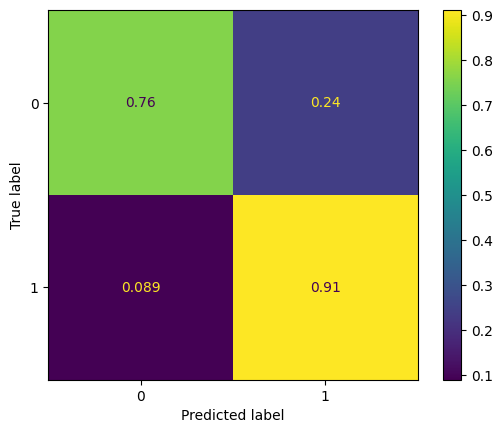

In [269]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [270]:
print('weighted f1: ', f1_score(y_test, lr_preds, average='weighted'))
print('micro f1: ', f1_score(y_test, lr_preds, average='micro'))
print('macro f1: ', f1_score(y_test, lr_preds, average='macro'))

weighted f1:  0.8078637854747521
micro f1:  0.7928220183486239
macro f1:  0.758895066988676


## Feature Importance

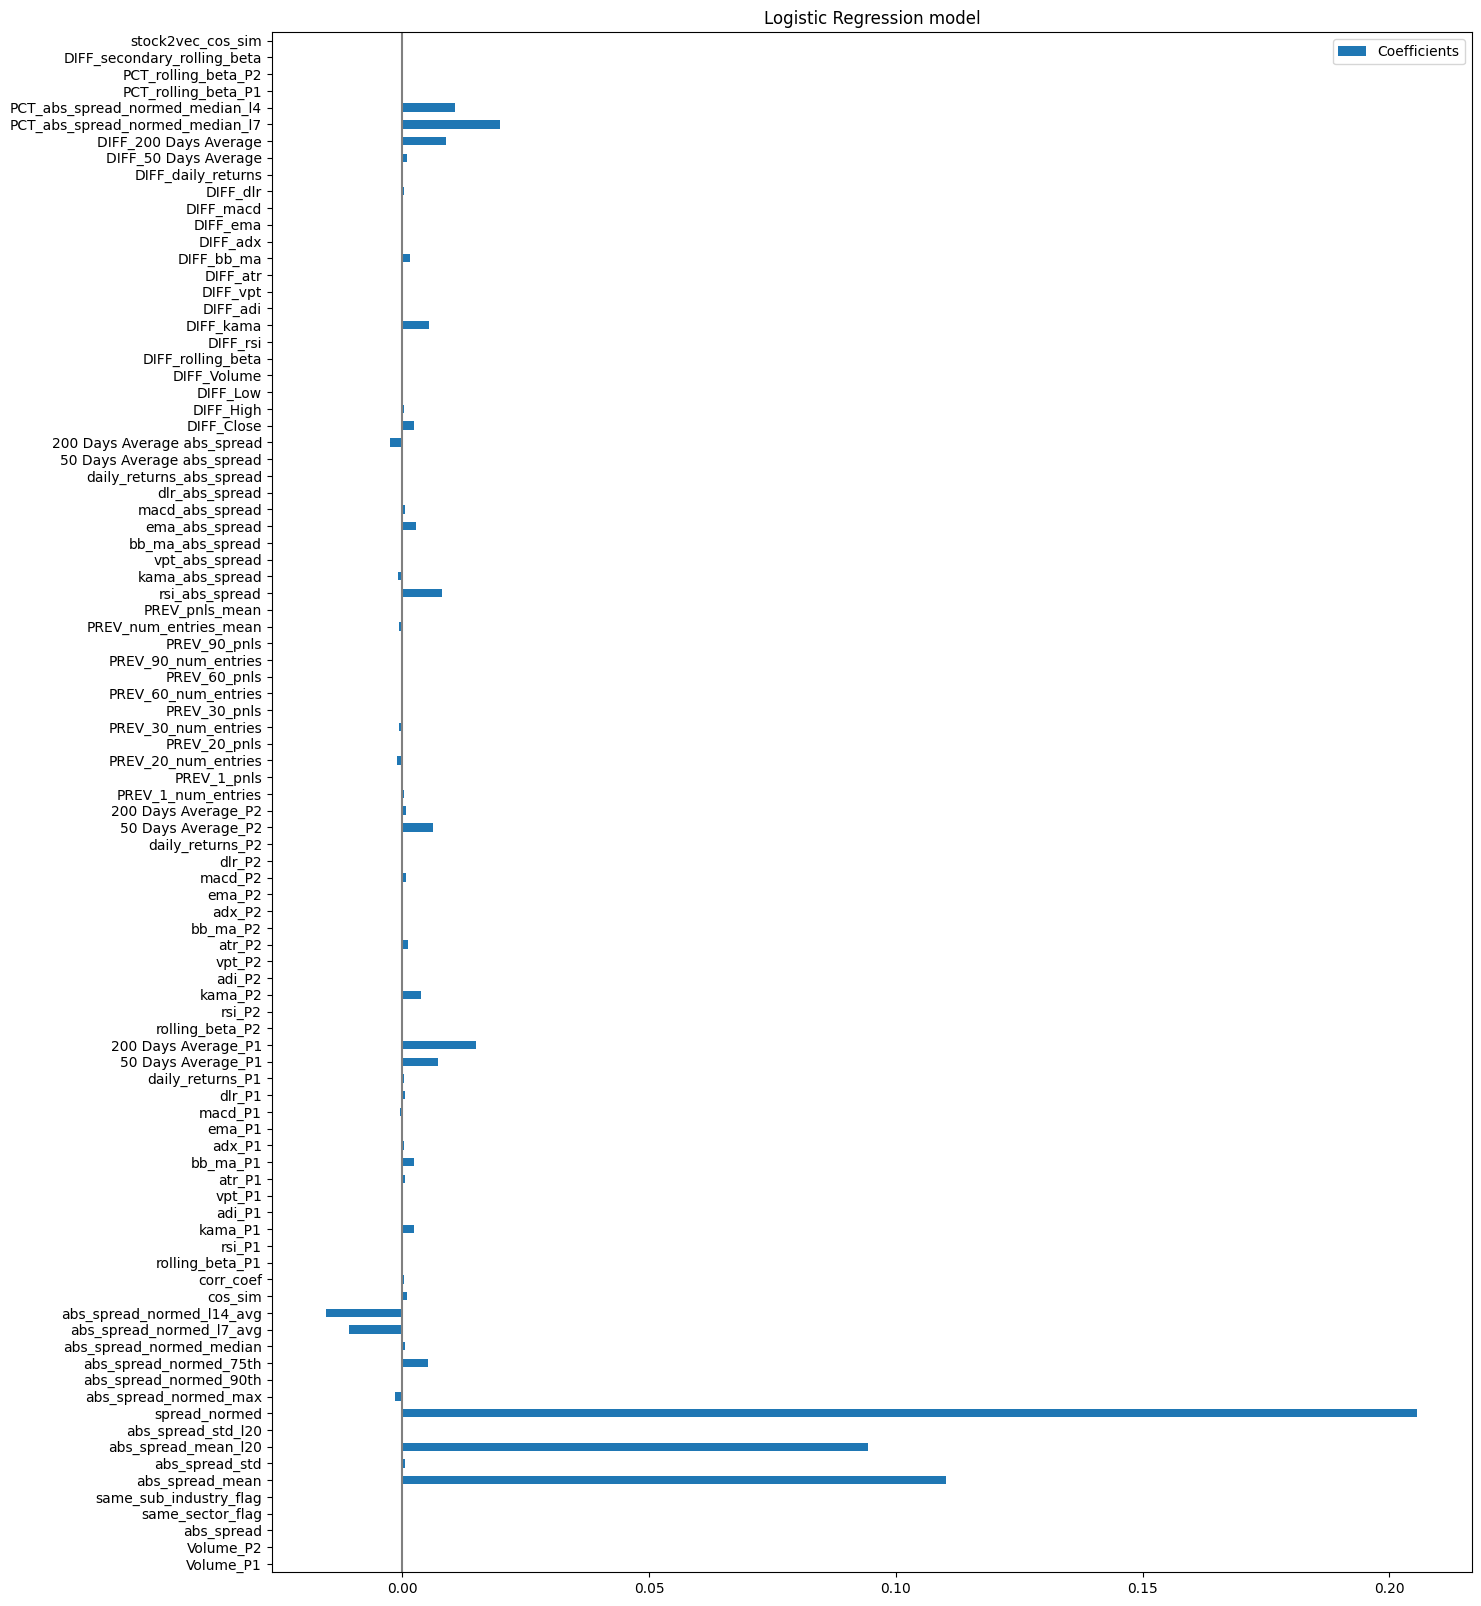

In [271]:
pi = permutation_importance(clf,scaled_X_test,y_test)

coefs = pd.DataFrame(
    pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
)

coefs.plot(kind="barh", figsize=(20, 20))
plt.title("Logistic Regression model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## GBM

### Optuna

In [272]:
def objective(trial):
    params = {
        'boosting':'dart',
        "objective": "binary",
#         "metric": "accuracy",
#         'class_weight':'balanced',
        "n_estimators": 300,
        "verbosity": -1,
        "bagging_freq": 1,
        'max_bin':trial.suggest_int('max_bin',64,1024),
        'max_depth':trial.suggest_int('max_depth',4,20),

        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train.drop(categorical_features,axis=1),y_train)
    predictions = model.predict(X_val.drop(categorical_features,axis=1))
    f1 = f1_score(y_val, predictions, average='weighted')
    return -1*f1

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-03-12 23:11:35,082] A new study created in memory with name: no-name-c63cb22a-be65-496d-bf09-259df5ec51c2
[I 2024-03-12 23:11:57,564] Trial 0 finished with value: -0.8124546225405437 and parameters: {'max_bin': 238, 'max_depth': 10, 'learning_rate': 0.00010931794677717533, 'num_leaves': 1527, 'subsample': 0.34792251981882893, 'colsample_bytree': 0.23804288818456065, 'min_data_in_leaf': 693}. Best is trial 0 with value: -0.8124546225405437.
[I 2024-03-12 23:12:20,046] Trial 1 finished with value: -0.8385656478728937 and parameters: {'max_bin': 991, 'max_depth': 8, 'learning_rate': 0.0019262813099058963, 'num_leaves': 1172, 'subsample': 0.8341069192966264, 'colsample_bytree': 0.32613216485553687, 'min_data_in_leaf': 171}. Best is trial 1 with value: -0.8385656478728937.
[I 2024-03-12 23:12:42,315] Trial 2 finished with value: -0.8290014405134714 and parameters: {'max_bin': 870, 'max_depth': 11, 'learning_rate': 0.04976890481990495, 'num_leaves': 1452, 'subsample': 0.2089138063534

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best F1:', study.best_value*(-1))

In [ ]:
hyper_params = study.best_params

In [ ]:
hyper_params = study.best_params
hyper_params['boosting']='dart'
hyper_params["objective"] = "binary"
# hyper_params["metric"] = 'l2'
#         'class_weight':'balanced',
hyper_params["n_estimators"] = 300

In [ ]:
y_train.value_counts()/len(y_train)

In [ ]:
gbm = lgb.LGBMClassifier(**hyper_params)
callbacks = [\
#             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
             lgb.log_evaluation(period=1)]

gbm.fit(X_train.drop(categorical_features,axis=1),y_train, 
        eval_set=[(X_val.drop(categorical_features,axis=1), y_val)],
        eval_metric='accuracy',
        callbacks=callbacks,
        feature_name = [f for f in features if f not in categorical_features],
#         categorical_feature=categorical_features
       )

In [ ]:
gbm_preds = gbm.predict(X_test.drop(categorical_features,axis=1))

## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, gbm_preds, labels=gbm.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbm.classes_)
disp.plot()

In [ ]:
print('weighted f1: ', f1_score(y_test, gbm_preds, average='weighted'))
print('micro f1: ', f1_score(y_test, gbm_preds, average='micro'))
print('macro f1: ', f1_score(y_test, gbm_preds, average='macro'))

In [ ]:
importances = gbm.feature_importances_
importances = pd.Series(importances,index=X_train.drop(categorical_features,axis=1).columns).sort_values(ascending=True)

In [ ]:
fig,ax=plt.subplots(figsize=[16,14])
importances.plot.barh(ax=ax)
ax.set_title("Feature Importance by Gain")
fig.tight_layout()

## Tree shap

In [ ]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer(X_test.drop(categorical_features,axis=1))

In [ ]:
X_test.shape

In [ ]:
shap_values.shape

In [ ]:
gbm.predict(X_test.drop(categorical_features,axis=1).iloc[0].values.reshape(1, -1))

In [ ]:
gbm.predict_proba(X_test.drop(categorical_features,axis=1).iloc[n].values.reshape(1, -1))

In [ ]:
n = 505
print(y_test.iloc[n])
plt.figure(figsize=(10,10))
shap.waterfall_plot(shap.Explanation(values=shap_values[n,:,y_test.iloc[n]],
                                     base_values = explainer.expected_value[y_test.iloc[n]],
                                     data = X_test.drop(categorical_features,axis=1).iloc[n],
                                     feature_names = X_test.drop(categorical_features,axis=1).columns),
                   max_display=15)
plt.show()

In [ ]:
X_test.drop(categorical_features,axis=1).shape

In [ ]:
shap.dependence_plot("spread_normed", shap_values.values[:,:,0], \
                     X_test.drop(categorical_features,axis=1),\
                     display_features=X_test.drop(categorical_features,axis=1).columns)


In [ ]:
stop

In [ ]:
import joblib
# save model
joblib.dump(gbm, '/home/ec2-user/Capstone/lgb.pkl')

In [ ]:
reloaded_gbm = joblib.load('/home/ec2-user/Capstone/lgb.pkl')

In [ ]:
reloaded_gbm.predict(X_test.drop(categorical_features,axis=1))

In [ ]:
features = gbm.booster_.feature_name()

In [ ]:
df.columns = ['_'.join(c.split(' ')) for c in df.columns]

In [ ]:
all_probas = gbm.predict_proba(X_test.drop(categorical_features,axis=1)).max(axis=1).shape

In [ ]:
px.histogram(data_for_mvp_model.drop_duplicates(subset=['Ticker_P1','Ticker_P2'])['predicted_prob'])

In [ ]:
data_for_mvp_model.shape

In [ ]:
data_for_mvp_model['binned_proba'] = pd.cut(data_for_mvp_model.predicted_prob,bins=np.arange(0,1.01,0.1),labels=np.arange(0,1.01,0.1)[1:])
data_for_mvp_model[['predicted_prob','binned_proba']]

In [ ]:
t1 = data_for_mvp_model.groupby(['Date','binned_proba']).pnls.mean().reset_index()
# t1.groupby(['binned_proba']).pnls.mean()
t1

In [ ]:
data_for_mvp_model.groupby(['binned_proba']).pnls.median().reset_index()

In [ ]:
px.scatter(data_for_mvp_model,'predicted_prob','pnls', trendline="ols", trendline_color_override="red")

In [ ]:
df['abs_spread_mean_20'] = df.groupby(['Ticker_P1','Ticker_P2']).rolling(20).abs_spread.mean().values

In [ ]:
for i in range(1,4):
    df['FUTURE_abs_spread_'+str(i)] = df.groupby(['Ticker_P1','Ticker_P2'])['abs_spread'].shift(-1*i)

df['FUTURE_abs_spread_avg'] = df[[c for c in df.columns if 'FUTURE_abs_spread_' in c]].mean(axis=1)

df['regr_label'] = df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean_20']+1.5*df['abs_spread_std'])
# df['PCT_CHANGE'] = (df['FUTURE_abs_spread_avg'] - df['abs_spread'])*100.0/df['abs_spread']
# df['direction'] = np.where(df['PCT_CHANGE'].abs()<3,0,np.where(df['PCT_CHANGE']>0,1,-1))
# df['direction'] = np.where((df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+1.5*df['abs_spread_std']))>0,1,0)
# df['direction'] = np.where((df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+0.1*df['abs_spread_std']))<0,1,0)


In [ ]:
data_for_mvp_model.groupby('direction').pnls.mean()

In [ ]:
data_for_mvp_model.groupby('predicted_class').pnls.mean()

In [ ]:
data_for_mvp_model['positive_pnl'] = np.where(data_for_mvp_model.pnls>0,1,0)

In [ ]:
data_for_mvp_model.groupby('direction').positive_pnl.sum()/data_for_mvp_model.direction.value_counts()

In [ ]:
data_for_mvp_model['binned_stock2vec_cos_sim'] = pd.cut(data_for_mvp_model.stock2vec_cos_sim,bins=np.arange(0,1.01,0.1),labels=np.arange(0,1.01,0.1)[1:])
data_for_mvp_model[['stock2vec_cos_sim','binned_stock2vec_cos_sim']]

In [ ]:
data_for_mvp_model.groupby('Date').predicted_prob.nlargest(5).describe(np.arange(0,1,0.1))

In [ ]:
plot_df = data_for_mvp_model[data_for_mvp_model.predicted_prob>=0.59]
# plot_df = plot_df[plot_df.Date == plot_df.Date.iloc[-1]]
px.scatter(plot_df,'stock2vec_cos_sim','pnls', trendline="ols", trendline_color_override="red")

In [ ]:
t2 = data_for_mvp_model.groupby(['Date','binned_stock2vec_cos_sim']).pnls.median().reset_index().dropna()
t2.groupby(['binned_stock2vec_cos_sim']).pnls.median()

In [ ]:
px.scatter(df.loc[data_for_mvp_model.index],'regr_label','pnls', trendline="ols", trendline_color_override="red")

In [ ]:
data_for_mvp_model = df.loc[X_test.index][['Date','Ticker_P1','Ticker_P2','Sector_P1','Sector_P2']+features+['direction','pnls']]
data_for_mvp_model['predicted_class'] = gbm_preds
data_for_mvp_model['predicted_prob'] = np.where(data_for_mvp_model['predicted_class']==1,\
                                                gbm.predict_proba(X_test.drop(categorical_features,axis=1)).max(axis=1),\
                                                gbm.predict_proba(X_test.drop(categorical_features,axis=1)).min(axis=1))
data_for_mvp_model.shape

In [ ]:
data_for_mvp_model.isna().sum().sort_values(ascending=False)

In [ ]:
data_for_mvp_model.to_csv('/home/ec2-user/Capstone/lgb_inputs.csv',index=False)

In [ ]:
gbm.predict(data_for_mvp_model[features])

In [ ]:
STOP

# Regression

In [ ]:
# TODO
# 1. for a random pair, check how much pnl changes
# 2. somehow down sample to remove repetition - features barely change, pnl barely change- bad
# 3. perhaps bucket pnls by 0.5% and treat as regression
# 4. then drop dupes by subset [t1,t2,pnl]
# 5. how to bring back those that just happens to be similar?

In [ ]:
# orig_df = df.copy()

In [ ]:
# df = orig_df

In [ ]:
# df = df[(df['Ticker_P1']=='SHW') & (df['Ticker_P2']=='MLM')]

In [ ]:
df.groupby('Date').apply(lambda x: np.percentile(x['pnls'].abs(),95)).describe(np.arange(0,1,0.1))

## Remove 0s?

In [ ]:
df[df.pnls==0].shape[0]*100.0/df.shape[0]

In [ ]:
# df = df[df.pnls!=0]


In [ ]:
# df = df[df.pnls!=-1]


## X,y split

In [ ]:
# df['DIFF_pnls'] = df['pnls'] - df['PREV_1_pnls']

In [ ]:
features = df.drop(categorical_features+['PNL_IS_0']+\
                   ['STOCK2VEC_'+ str(i) + '_P1' for i in range(0,32)]+\
                   ['STOCK2VEC_'+ str(i) + '_P2' for i in range(0,32)]+
                   [\
                    'Date','Ticker_P1','Ticker_P2','SPY_Close_P1','SPY_Close_P2',\
                    'num_entries','pnls','direction','stock2vec_cos_sim',\
                    'SPY_return','days_till_first_entry','successful_pair_trading','both_legs_profited'
                   ]+[c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c],axis=1).columns.tolist()+categorical_features
label = 'direction'

In [ ]:
# features = ['Volume_P1',
#  'Volume_P2',
#  'abs_spread',
#  'abs_spread_mean',
#  'abs_spread_std',
#  'abs_spread_mean_l28',
#  'abs_spread_std_l28',
#  'spread_normed',
#  'abs_spread_normed_l7_avg',
#  'abs_spread_normed_l14_avg',
#  'cos_sim',
#  'corr_coef',
#  'SPY_Close',
#  'rolling_beta_P1',
#  'rsi_P1',
#  'kama_P1',
#  'adi_P1',
#  'vpt_P1',
#  'atr_P1',
#  'bb_ma_P1',
#  'adx_P1',
#  'ema_P1',
#  'macd_P1',
#  'dlr_P1',
#  'daily_returns_P1',
#  '50 Days Average_P1',
#  '200 Days Average_P1',
#  'rolling_beta_P2',
#  'rsi_P2',
#  'kama_P2',
#  'adi_P2',
#  'vpt_P2',
#  'atr_P2',
#  'bb_ma_P2',
#  'adx_P2',
#  'ema_P2',
#  'macd_P2',
#  'dlr_P2',
#  'daily_returns_P2',
#  '50 Days Average_P2',
#  '200 Days Average_P2',
#  'PREV_1_num_entries',
#  'PREV_1_pnls',
#  'DIFF_Volume',
#  'DIFF_rolling_beta',
#  'DIFF_rsi',
#  'DIFF_kama',
#  'DIFF_adi',
#  'DIFF_vpt',
#  'DIFF_atr',
#  'DIFF_bb_ma',
#  'DIFF_adx',
#  'DIFF_ema',
#  'DIFF_macd',
#  'DIFF_dlr',
#  'DIFF_daily_returns',
#  'DIFF_50 Days Average',
#  'DIFF_200 Days Average',
#  'PCT_abs_spread_mean_l28_300']+categorical_features

In [ ]:
df.isna().sum().sort_values(ascending=False)

In [ ]:
X = df[features]
y = df[label]

In [ ]:
# y = pd.Series(np.where(y.abs()<1,0,np.where(y<0,-1,1)))
# y = pd.Series(np.where(y>=8,1,0))

In [ ]:
y.value_counts()

## Train test split

In [ ]:
y.abs().describe(np.arange(0,1,0.1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

### Filter Outliers?

In [ ]:
# u = np.mean(y_train)
# s = np.std(y_train)
# y_train = y_train[(y_train>(u-2*s)) & (y_train<(u+2*s))]
# X_train = X_train.loc[y_train.index]

In [ ]:
# y_pnls = X_train['PREV_1_pnls'] + y_train
# print(y_pnls.shape)
# y_pnls = y_pnls[y_pnls.abs() >= 2.5]
# print(y_pnls.shape)
# X_train = X_train.loc[y_pnls.index]
# y_train = y_train.loc[y_pnls.index]
# del y_pnls

In [ ]:
# y_pnls = X_val['PREV_1_pnls'] + y_val
# print(y_pnls.shape)
# y_pnls = y_pnls[y_pnls.abs() >= 2.5]
# print(y_pnls.shape)
# X_val = X_val.loc[y_pnls.index]
# y_val = y_val.loc[y_pnls.index]
# del y_pnls

In [ ]:
# y_train = y_train.drop_duplicates()
# X_train = X_train.loc[y_train.index]

In [ ]:
# undersample = RandomUnderSampler(sampling_strategy='not minority')
undersample = RandomUnderSampler(sampling_strategy='majority')

X_train, y_train = undersample.fit_resample(X_train, y_train)
X_val, y_val = undersample.fit_resample(X_val, y_val)

In [ ]:
y_train.value_counts()

In [ ]:
y_val.value_counts()

In [ ]:
y_test.value_counts()

## GBM

In [ ]:
def objective(trial):
    params = {
        'boosting':'goss',
        "objective": "binary",
#         'device':'gpu',
#         "metric": "accuracy",
#         'class_weight':'balanced',
#         'is_unbalance':True,
        "n_estimators": 300,
        "verbosity": -1,
        'n_jobs':16,
#         "bagging_freq": 1,
        'max_bin':trial.suggest_int('max_bin',64,1024),
        'max_depth':trial.suggest_int('max_depth',4,30),

        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train.drop(categorical_features,axis=1),y_train)
    predictions = model.predict(X_val.drop(categorical_features,axis=1))
    f1 = f1_score(y_val, predictions, average='weighted')
    return -1*f1

In [ ]:
# def objective(trial):
#     params = {
#         'boosting':'goss',
#         "objective": "mse",
# #         'device':'gpu',
#         "metric": 'l2',
# #         'class_weight':'balanced',
#         "n_estimators": 600,
#         "verbosity": -1,
# #         "bagging_freq": 1,
#         'max_bin':trial.suggest_int('max_bin',64,1024),
#         'max_depth':trial.suggest_int('max_depth',4,30),

#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
#     }

#     model = lgb.LGBMRegressor(**params)
#     model.fit(X_train.drop(categorical_features,axis=1),y_train)
#     predictions = model.predict(X_val.drop(categorical_features,axis=1))
#     mae = np.mean(abs(predictions-y_val))
#     mse = np.mean((predictions-y_val)**2)

#     return mse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [ ]:
df[[c for c in features if c not in categorical_features]+[label]].corr()[label].abs().sort_values(ascending=False).head(20)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best mae:', study.best_value)

In [ ]:
hyper_params = study.best_params
hyper_params['boosting']='goss'
hyper_params["objective"] = "binary"
# hyper_params["metric"] = 'accuracy'
#         'class_weight':'balanced',
hyper_params["n_estimators"] = 300

In [ ]:
hyper_params

In [ ]:
# hyper_params = {
# #     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'mae',
#     'metric': ['l1'],
# #     'eval_metric': ['l1'],
# #     'early_stopping_rounds':10,
#     'learning_rate': 0.2,
# #     'feature_fraction': 0.9,
# #     'bagging_fraction': 0.7,
# #     'bagging_freq': 10,
#     'verbosity': 1,
# #     "max_depth": 8,
# #     "num_leaves": 128,  
# #     "max_bin": 512,
#     "num_iterations": 200,
#     "importance_type":"gain"
    
# #     "silent":False
# }

In [ ]:
# gbm = lgb.LGBMRegressor(**hyper_params)
gbm = lgb.LGBMClassifier(**hyper_params)

callbacks = [\
#             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
             lgb.log_evaluation(period=1)]

gbm.fit(X_train.drop(categorical_features,axis=1),y_train, 
        eval_set=[(X_val.drop(categorical_features,axis=1), y_val )],
#         eval_metric='l1',
        callbacks=callbacks,
#         feature_name = features,
#         categorical_feature=categorical_features
       )

In [ ]:
preds = gbm.predict(X_test.drop(categorical_features,axis=1))
cm = confusion_matrix(y_test, preds, labels=gbm.classes_,normalize='true')
cm

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbm.classes_)
disp.plot()

### GBM feature importance

In [ ]:
importances = gbm.feature_importances_
importances = pd.Series(importances,index=X_train.drop(categorical_features,axis=1).columns).sort_values(ascending=True)

In [ ]:
fig,ax=plt.subplots(figsize=[20,14])
importances.plot.barh(ax=ax)
ax.set_title("Feature Importance by Gain")
fig.tight_layout()

In [ ]:
print(f1_score(y_test, preds, average='weighted'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='macro'))

In [ ]:
# pi = permutation_importance(gbm,X_test.drop(categorical_features,axis=1),y_test)

# coefs = pd.DataFrame(
#     pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
# )
# coefs.plot(kind="barh", figsize=(20, 20))
# plt.title("Logistic Regression model")
# plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)

## Error Analysis

In [ ]:
preds = gbm.predict(X_test.drop(categorical_features,axis=1))

In [ ]:
results = pd.DataFrame({'preds':preds,'true':y_test,'prev':X_test['PREV_1_pnls']})
results.index = X_test.index
results

In [ ]:
big_pnl_results = results[results['true']>=2.5]
(big_pnl_results['preds'] - big_pnl_results['true']).abs().mean()/big_pnl_results['true'].abs().mean()

In [ ]:
big_pnl_results

In [ ]:
(big_pnl_results['preds'] - big_pnl_results['true']).abs().describe(np.arange(0,1,0.1))

In [ ]:
results.describe(np.arange(0,1,0.1))

In [ ]:
df.tail()

In [ ]:
one_pair = df.loc[X_test.index][(df['Ticker_P1']=='ISRG')&(df['Ticker_P2']=='LRCX')].index
one_pair

In [ ]:
df.tail()

In [ ]:
px.line(results.loc[one_pair],results.loc[one_pair].index,y=results.columns)

In [ ]:
mae = (preds-y_test).abs().mean()
mae

In [ ]:
mean_abs_label = ((y_test).mean() - y_test).abs().mean()
# mean_abs_label = (X_test['pnls']).abs().mean()

mean_abs_label

In [ ]:
mae/mean_abs_label

In [ ]:
mae_AR1 = (X_test.PREV_1_pnls - (y_test+X_test['PREV_1_pnls'])).abs().mean()
mae_AR1

In [ ]:
mae/mae_AR1

## Linear Regression

In [ ]:
# Create correlation matrix
corr_matrix = X_train.drop(categorical_features,axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop = ['High_P1','Low_P1']

In [ ]:
scaler = StandardScaler().fit(X_train.drop(categorical_features+to_drop,axis=1))
scaled_X_train = scaler.transform(X_train.drop(categorical_features+to_drop,axis=1))
scaled_X_val = scaler.transform(X_val.drop(categorical_features+to_drop,axis=1))
scaled_X_test = scaler.transform(X_test.drop(categorical_features+to_drop,axis=1))

In [ ]:
regr = LinearRegression()

# Train the model using the training sets
regr.fit(scaled_X_train, y_train)

# Make predictions using the testing set
lr_preds = regr.predict(scaled_X_test)

In [ ]:
coef_df = pd.DataFrame({'coef':regr.coef_,'feature_name':X_train.drop(categorical_features+to_drop,axis=1).columns.tolist()})
coef_df

In [ ]:
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df.sort_values('abs_coef',ascending=False).head(15)

In [ ]:
pi = permutation_importance(regr,scaled_X_test,y_test)

coefs = pd.DataFrame(
    pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features+to_drop,axis=1).columns
)


coefs.plot(kind="barh", figsize=(20, 20))
plt.title("LR model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
lr_results = pd.DataFrame({'preds':lr_preds,'true':y_test,'prev':X_test['PREV_1_pnls'].values})
lr_results['predicted_pnl'] = lr_results['preds']+lr_results['prev']
lr_results['actual_pnl'] = lr_results['true']+lr_results['prev']

lr_results

In [ ]:
lr_pnl_is_0 = lr_results[lr_results.true==0]
lr_pnl_not_0 = lr_results[lr_results.true!=0]

In [ ]:
mae = (lr_pnl_not_0.preds-lr_pnl_not_0.true).abs().mean()
mae

In [ ]:
mae/mean_abs_label

In [ ]:
px.line(lr_results.loc[one_pair],lr_results.loc[one_pair].index,y=lr_results.columns)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(verbose=2,n_jobs=-1)

In [ ]:
rf.fit(X_train.drop(categorical_features,axis=1),y_train)

In [ ]:
preds = rf.predict(X_test.drop(categorical_features,axis=1))

In [ ]:
mae = (preds-y_test).abs().mean()
mae

In [ ]:
mae/mean_abs_label

# RFE

In [ ]:
len(features)

In [ ]:
sel = RFE(gbm, step=1, n_features_to_select=80, verbose=1)
sel.fit(X_train.drop(categorical_features,axis=1), y_train)
print(sel.ranking_)

In [ ]:
reduced_list = [features[i]for i,c in enumerate(sel.support_) if c]
reduced_list

In [ ]:
gbm = lgb.LGBMRegressor(**hyper_params)
# gbm = lgb.LGBMClassifier(**hyper_params)

callbacks = [\
#             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
             lgb.log_evaluation(period=1)]

gbm.fit(X_train[reduced_list],y_train, 
        eval_set=[(X_val[reduced_list], y_val )],
#         eval_metric='l1',
        callbacks=callbacks,
#         feature_name = features,
#         categorical_feature=categorical_features
       )

In [ ]:
preds = gbm.predict(X_test[reduced_list])

In [ ]:
mae = (preds-y_test).abs().mean()
mae

# ANN

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = MinMaxScaler().fit(X_train.drop(categorical_features,axis=1))
scaled_X_train = scaler.transform(X_train.drop(categorical_features,axis=1))
scaled_X_val = scaler.transform(X_val.drop(categorical_features,axis=1))
scaled_X_test = scaler.transform(X_test.drop(categorical_features,axis=1))

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.25),    
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1)
])

model.compile(loss='mae',
             optimizer = tf.keras.optimizers.Adam(0.01),
             metrics=['mae'])

history = model.fit(scaled_X_train, y_train, batch_size=32,epochs=30, validation_data=(scaled_X_val, y_val))

In [ ]:
df[df.num_entries>1].shape[0]/len(df)

In [ ]:
preds = model.predict(scaled_X_test)

In [ ]:
mae = (preds.ravel()-y_test).abs().mean()

In [ ]:
mae/mean_abs_label

In [ ]:
# TO Get:
# 1. confusion matrix for lgb, CNN, lgb+stock2vec, logistic regression, f1
# 2. f1 over time
# 3. f1 by categories
# 4. f1 in different macro market environments
# 5. f1 over label period

In [ ]:
# lgb > lr
# # df['abs_spread_mean'] = df['abs_spread_mean_l20']

# for i in range(17,20):
#     df['FUTURE_abs_spread_'+str(i)] = df.groupby(['Ticker_P1','Ticker_P2'])['abs_spread'].shift(-1*i)

# df['FUTURE_abs_spread_avg'] = df[[c for c in df.columns if 'FUTURE_abs_spread_' in c]].mean(axis=1)

# df['PCT_CHANGE'] = (df['FUTURE_abs_spread_avg'] - df['abs_spread'])*100.0/df['abs_spread']
# # df['direction'] = np.where(df['PCT_CHANGE'].abs()<3,0,np.where(df['PCT_CHANGE']>0,1,-1))
# # df['direction'] = np.where((df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+1.5*df['abs_spread_std']))>0,1,0)
# df['direction'] = np.where((df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+0.1*df['abs_spread_std']))<0,1,0)

# df['direction'].value_counts()
# # df['direction'] = df['PCT_CHANGE']